In [1]:
import os
import numpy as np
import scipy
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping


In [2]:
data_dir = "D:/Curated X-Ray Dataset/"
batch_size = 16
img_size = (224, 224)  # VGG16 input size

# datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# train_generator = datagen.flow_from_directory(
#     data_dir,
#     target_size=img_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='training'
# )

# validation_generator = datagen.flow_from_directory(
#     data_dir,
#     target_size=img_size,
#     batch_size=batch_size,
#     class_mode='categorical',
#     subset='validation'
# )


In [3]:
# Create lists to store file paths and corresponding labels
file_paths = []
labels = []

# Iterate through each class directory
for class_label in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_label)
    
    # Only consider directories
    if os.path.isdir(class_path):
        # Iterate through images in the class directory
        for filename in os.listdir(class_path):
            file_path = os.path.join(class_path, filename)
            file_paths.append(file_path)
            labels.append(class_label)

# Split the data into training and temporary sets
X_train, X_temp, y_train, y_temp = train_test_split(file_paths, labels, test_size=0.1, random_state=42)

# Split the temporary set into validation and test sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

# Print the sizes of each set
print(f"Number of training samples: {len(X_train)}")
print(f"Number of validation samples: {len(X_val)}")
print(f"Number of test samples: {len(X_test)}")

Number of training samples: 8287
Number of validation samples: 736
Number of test samples: 185


In [4]:
train_df = pd.DataFrame({'filename': X_train, 'label': y_train})
val_df = pd.DataFrame({'filename': X_val, 'label': y_val})
test_df = pd.DataFrame({'filename': X_test, 'label': y_test})

# Class distribution before undersampling
class_distribution_before = Counter(y_train)
print("Class distribution before undersampling:", class_distribution_before)

# Perform undersampling on the training set
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = undersample.fit_resample(np.array(X_train).reshape(-1, 1), y_train)

# Extract lists from the resampled arrays
X_train_resampled = X_train_resampled.flatten().tolist()

# Shuffle the resampled data
X_train_resampled, y_train_resampled = shuffle(X_train_resampled, y_train_resampled, random_state=42)

# Class distribution after undersampling
class_distribution_after = Counter(y_train_resampled)
print("Class distribution after undersampling:", class_distribution_after)

train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    pd.DataFrame({'filename': X_train_resampled, 'label': y_train_resampled}),
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='filename',
    y_col='label',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Class distribution before undersampling: Counter({'Normal': 2938, 'Pneumonia-Bacterial': 2715, 'Pneumonia-Viral': 1479, 'COVID-19': 1155})
Class distribution after undersampling: Counter({'COVID-19': 1155, 'Normal': 1155, 'Pneumonia-Bacterial': 1155, 'Pneumonia-Viral': 1155})
Found 4620 validated image filenames belonging to 4 classes.
Found 736 validated image filenames belonging to 4 classes.
Found 185 validated image filenames belonging to 4 classes.


In [5]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

In [6]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with softmax activation
output = layers.Dense(4, activation='softmax')(x)  # Assuming 4 classes

# # Model without Added Layer
model = models.Model(base_model.input, output)

#Model with added layer
# model = models.Sequential()
# model.add(base_model)
# model.add(layers.Flatten())
# model.add(layers.Dense(256, activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(4, activation='softmax'))  # Assuming 4 classes (Normal, Pneumonia-Viral, Pneumonia-Bacterial, COVID-19)


initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


#Early Stopping
callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # You can also use 'val_accuracy' as the monitor
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# 'adam' = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Compile without LR Schedule
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the Model
epochs = 20  # You can adjust this based on your needs

In [7]:
# history = model.fit(
#     train_generator,
#     epochs=epochs,
#     validation_data=validation_generator,
#     callbacks=[early_stopping]  # Add the EarlyStopping callback here
# )

# learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=4, 
#                                             min_lr=1e-7, verbose=1, mode="min")


history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,  # Use the validation generator created from the DataFrame
    callbacks=[callback]
)

# Evaluate the Model
_, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Epoch 1/20
289/289 [==============================] - 51s 157ms/step - loss: 0.5707 - accuracy: 0.7820 - val_loss: 0.5054 - val_accuracy: 0.8125
Epoch 2/20
289/289 [==============================] - 42s 145ms/step - loss: 0.3527 - accuracy: 0.8509 - val_loss: 0.4167 - val_accuracy: 0.8356
Epoch 3/20
289/289 [==============================] - 41s 143ms/step - loss: 0.2772 - accuracy: 0.8842 - val_loss: 0.3689 - val_accuracy: 0.8519
Epoch 4/20
289/289 [==============================] - 41s 142ms/step - loss: 0.2586 - accuracy: 0.8924 - val_loss: 0.4166 - val_accuracy: 0.8438
Epoch 5/20
289/289 [==============================] - 41s 143ms/step - loss: 0.2235 - accuracy: 0.9037 - val_loss: 0.4543 - val_accuracy: 0.8193
Epoch 6/20
46/46 [==============================] - 6s 126ms/step - loss: 0.3689 - accuracy: 0.8519
Validation Accuracy: 85.19%


In [8]:
# Predict on test data
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = val_generator.classes

# Convert one-hot encoded labels to integers
class_labels = list(val_generator.class_indices.keys())

# Generate classification report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:\n", report)

46/46 [==============================] - 6s 124ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.11      0.11      0.11       102
           1       0.34      0.34      0.34       274
           2       0.28      0.28      0.28       226
           3       0.23      0.22      0.23       134

    accuracy                           0.27       736
   macro avg       0.24      0.24      0.24       736
weighted avg       0.27      0.27      0.27       736



In [9]:
y_true[:30]


[1,
 2,
 1,
 0,
 1,
 3,
 1,
 3,
 2,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 0,
 2,
 1,
 3,
 2,
 1,
 0,
 2,
 1,
 0,
 0]

In [10]:
y_pred_classes[:30]

array([0, 0, 1, 0, 1, 2, 2, 1, 1, 2, 3, 1, 1, 1, 2, 3, 2, 1, 1, 2, 1, 2,
       0, 2, 3, 2, 3, 1, 1, 2], dtype=int64)

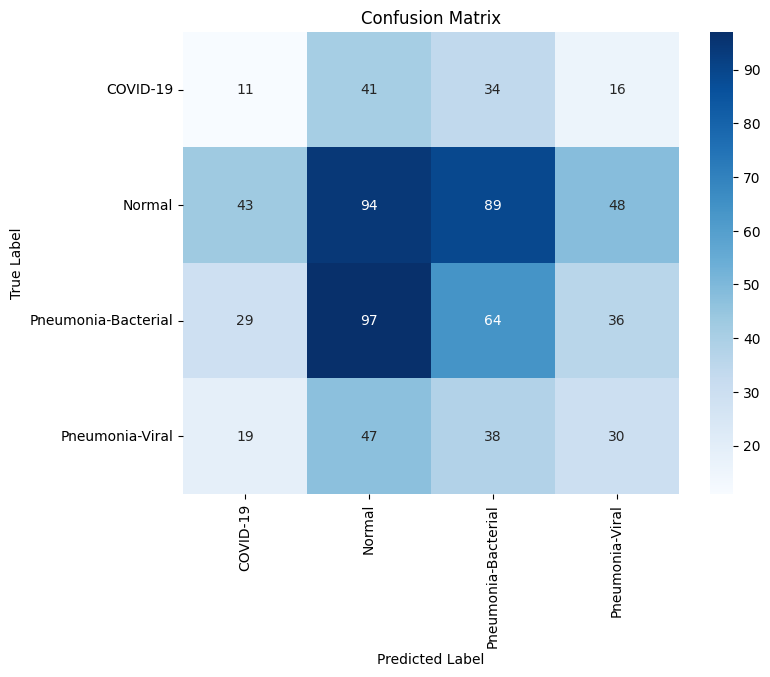

In [11]:
# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [1]:
import tensorflow as tf
tf.test.is_built_with_cuda()


True

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]